In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv

In [6]:
load_dotenv()

True

In [12]:
model = ChatOpenAI(model = 'gpt-4o-mini')

In [15]:
class ReviewSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description= 'the sentiment of the review')

In [17]:
class Diagnosis_schema(BaseModel):
    issue_type: Literal['Delayed Services', 'Product Quality', 'Support Service', 'Performance issue', 'Bug', 'Others'] = Field(description='root cause of the issue')
    customer_tone: Literal['Angry', 'Frustrated', 'Disappointed', 'calm'] = Field(description= 'the tone of the customer in the complain')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [18]:
structured_model = model.with_structured_output(ReviewSchema)
structured_model2 = model.with_structured_output(Diagnosis_schema)

In [9]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: str
    response: str

In [40]:
def find_sentiment(state: ReviewState):
    review = state['review']
    prompt = f'For the following review, find out the sentiment  \n review - {review}'
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal['positive_response', 'diagnosis']:
    #sentiment = state['sentiment']
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'diagnosis'

def positive_response(state: ReviewSchema):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""
    output = model.invoke(prompt).content
    return {'response': output}


def diagnosis(state: ReviewState):
     prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
     response = structured_model2.invoke(prompt)
     return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['customer_tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message."""
    output = model.invoke(prompt).content
    return {'response': output}



In [41]:
graph = StateGraph(ReviewState)
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('diagnosis', diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('diagnosis', 'negative_response')
graph.add_edge('negative_response', END)




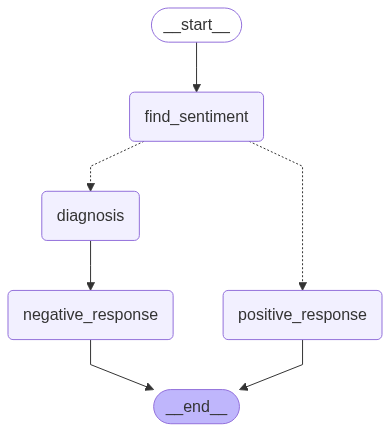

In [42]:
workflow = graph.compile()
workflow

In [43]:
initial_state = {'review': """I had high hopes for this product based on the description and a few initial reviews, but after using it for a couple of weeks, I am honestly disappointed. The performance is sluggish and inconsistent — it takes forever to start up and crashes randomly during use.

What worse is that it seems to get worse over time. The battery (if it has one) drains ridiculously fast, and it heats up even during light use. I expected smooth functionality and some level of reliability, but it just does not deliver.

Customer support has not been helpful either — all I got was a scripted response. For the price I paid, I expected a lot better. Would not recommend unless major improvements are made."""}
output = workflow.invoke(initial_state)

In [45]:
print(output['response'])
print(output['diagnosis'])


Subject: We're Here to Help with Your Performance Issue

Dear [User's Name],

I hope this message finds you well. I want to first thank you for bringing your performance issue to our attention. I understand how disappointing it can be when things don’t work as expected, especially when you're relying on our service.

I want to assure you that we’re here to help you resolve this as quickly as possible. To better assist you, could you please provide a few more details regarding the specific nature of the performance issue you are experiencing? For instance, if you could let us know the tasks or features that are causing problems, as well as any error messages you may be encountering, it would be extremely helpful.

In the meantime, here are a few troubleshooting steps that may help alleviate the issue:

1. Clear your cache and cookies.
2. Ensure that you have the latest version of the software.
3. Restart your device.

I appreciate your patience as we work together to find a solution. Yo

In [46]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
output = workflow.invoke(intial_state)
print(output['response'])
print(output['diagnosis'])

Subject: We're Here to Help You with the Bug Issue

Hi [User's Name],

Thank you for reaching out to us, and I'm truly sorry to hear that you're experiencing a bug issue. I understand how frustrating this can be, especially when you’re relying on the system to work smoothly.

I want to assure you that your concerns are important to us, and we are committed to resolving this as quickly as possible. Could you please provide me with a few more details about the bug? Specifically, it would be helpful to know what actions you were taking when the issue occurred, any error messages you may have seen, and the device or platform you are using.

Once I have that information, I'll be able to investigate the issue more effectively and work towards a solution. If you have any urgent tasks, please let me know, and I can prioritize your case.

Thank you for your patience. I’m here to help!

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]
{'issue_type': 'Bug', 'customer_tone